## Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import logging
import os

import pandas as pd
from matplotlib import pyplot as plt

import amp_research.price_movement_analysis as pma
import core.signal_processing as sigp
import helpers.dbg as dbg
import helpers.env as env
import helpers.printing as pri
import helpers.s3 as hs3
import vendors.kibot.utils as kut

In [2]:
print(env.get_system_signature())

pri.config_notebook()

dbg.init_logger(verb=logging.INFO)

_LOG = logging.getLogger(__name__)

# Packages
         python: 3.7.3
         joblib: 0.13.2
          numpy: 1.16.4
         pandas: 0.24.2
        pyarrow: - (can't import)
          scipy: 1.3.0
        seaborn: 0.9.0
        sklearn: 0.21.2
    statsmodels: 0.10.0
# Last commits:
  * d8bd788 Julia    PartTask218: Print in descending order for negative values, drop nans ( 7 minutes ago) Wed Oct 16 19:28:28 2019  (HEAD -> PartTask218_PRICE_Large_price_movement_analysis, origin/PartTask218_PRICE_Large_price_movement_analysis)
  * 2ed8da1 Julia    PartTask218: Drop nans using core.explore                         (10 minutes ago) Wed Oct 16 19:25:59 2019           
  * 4b089e0 Julia    PartTask218: Change order to ascending for negative movements     (35 minutes ago) Wed Oct 16 19:00:42 2019           


## Helper functions

In [3]:
SYMBOL = "CL"

In [ ]:
def get_top_100(series, ascending=False):
    # Cannot use this: series = coex.drop_na(pd.DataFrame(series))['ret_0']
    # with resample
    series = series.dropna()
    return series.sort_values(ascending=ascending).head(100)


def get_zscored_kibot_returns(
    prices: pd.DataFrame, period: str, tau: int, demean: bool = False
):
    # Compute returns.
    rets = pma.compute_kibot_returns(prices, period)
    # z-score.
    zscored_rets = sigp.rolling_zscore(rets, tau, demean=demean)
    _LOG.debug("zscored_rets=\n%s", zscored_rets.head())
    return zscored_rets

# Load daily and minutely data

In [5]:
# Daily data.
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_daily/%s.csv.gz"
)
file_name = kibot_path % SYMBOL

daily_prices = kut.read_data(file_name, nrows=None)

daily_prices.tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_daily/CL.csv.gz',) kwargs={'nrows': None}


,open,high,low,close,vol
date,,,,,
2019-07-18,56.72,57.45,54.85,55.42,764491
2019-07-19,55.84,56.49,55.12,55.76,710948


In [6]:
# Minute data.
s3_path = hs3.get_path()
kibot_path = os.path.join(
    s3_path, "kibot/All_Futures_Continuous_Contracts_1min/%s.csv.gz"
)
file_name = kibot_path % SYMBOL
minutely_prices = kut.read_data(file_name, nrows=None)

minutely_prices.tail(2)

args=('s3://default00-bucket/kibot/All_Futures_Continuous_Contracts_1min/CL.csv.gz',) kwargs={'nrows': None}


,open,high,low,close,vol,time
datetime,,,,,,
2019-07-19 16:58:00,55.89,55.93,55.88,55.92,49,16:58:00
2019-07-19 16:59:00,55.91,55.92,55.86,55.86,131,16:59:00


In [7]:
# TODO(Julia): Should we move the code to downsample in kut?
five_min_prices = minutely_prices.resample("5Min").last()

In [8]:
five_min_prices.head()

,open,high,low,close,vol,time
datetime,,,,,,
2009-09-27 18:00:00,66.39,66.46,66.39,66.46,14.0,18:04:00
2009-09-27 18:05:00,66.39,66.39,66.37,66.38,4.0,18:09:00
2009-09-27 18:10:00,66.37,66.39,66.37,66.39,5.0,18:14:00
2009-09-27 18:15:00,66.41,66.41,66.38,66.38,6.0,18:19:00
2009-09-27 18:20:00,66.32,66.32,66.30,66.30,5.0,18:24:00


# Daily price movements

In [ ]:
tau = 18
zscored_rets = get_zscored_kibot_returns(daily_prices, "daily", tau=tau)

abs_zscored_rets = zscored_rets.abs()
pos_zscored_rets = zscored_rets.loc[zscored_rets >= 0]
neg_zscored_rets = zscored_rets.loc[zscored_rets < 0]

top_daily_movements = get_top_100(abs_zscored_rets)

top_daily_movements.head(10)

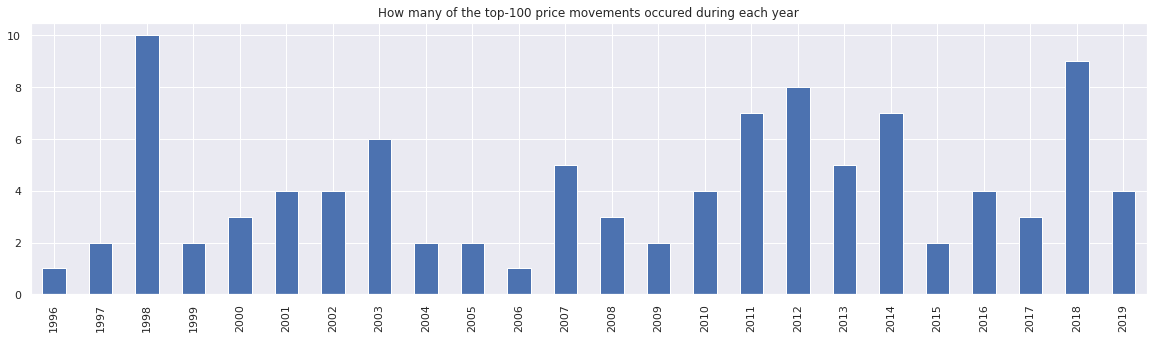

In [10]:
top_daily_movements.index.year.value_counts(sort=False).plot(kind="bar")
plt.title("How many of the top-100 price movements occured during each year")
plt.show()

In [11]:
zscored_rets.resample("Y").apply(get_top_100)

date        date      
1996-12-31  1996-09-03    2.141749
            1996-10-15    1.559034
            1996-12-03    1.502157
            1996-09-12    1.434554
            1996-08-30    1.367639
            1996-10-04    1.342593
            1996-09-25    1.274381
            1996-12-16    1.261530
            1996-12-06    1.161479
            1996-10-08    1.156479
            1996-08-23    1.153066
            1996-09-19    1.044562
            1996-08-20    1.039710
            1996-10-14    1.003564
            1996-08-19    1.000000
            1996-09-09    0.974478
            1996-12-17    0.929521
            1996-09-11    0.883376
            1996-09-30    0.880155
            1996-12-26    0.852903
            1996-11-20    0.822971
            1996-11-22    0.793647
            1996-10-21    0.778211
            1996-12-13    0.647858
            1996-09-26    0.646597
            1996-08-29    0.612505
            1996-09-13    0.579171
            1996-12-02    0.4273

In [12]:
top_daily_movements_by_year = zscored_rets.resample("Y").apply(get_top_100)
top_daily_movements_by_year.head()

date        date      
1996-12-31  1996-09-03    2.141749
            1996-10-15    1.559034
            1996-12-03    1.502157
            1996-09-12    1.434554
            1996-08-30    1.367639
Name: ret_0, dtype: float64

In [13]:
top_daily_movements_by_year.tail()

date        date      
2019-12-31  2019-02-01   -0.203385
            2019-04-16   -0.233868
            2019-05-20   -0.248263
            2019-06-18   -0.312890
            2019-06-12   -0.343229
Name: ret_0, dtype: float64

In [14]:
top_daily_pos_movements_by_year = pos_zscored_rets.resample("Y").apply(
    get_top_100
)
top_daily_pos_movements_by_year.head()

date        date      
1996-12-31  1996-09-03    2.141749
            1996-10-15    1.559034
            1996-12-03    1.502157
            1996-09-12    1.434554
            1996-08-30    1.367639
Name: ret_0, dtype: float64

In [15]:
top_daily_neg_movements_by_year = neg_zscored_rets.resample("Y").apply(
    get_top_100, True
)
top_daily_neg_movements_by_year.head()

date        date      
1996-12-31  1996-11-18   -2.952996
            1996-09-17   -1.933235
            1996-12-12   -1.865632
            1996-09-16   -1.716851
            1996-10-11   -1.588559
Name: ret_0, dtype: float64

# 1-min movements

In [ ]:
tau = 18

zscored_1min_rets = get_zscored_kibot_returns(
    minutely_prices, "minutely", tau=tau
)

abs_zscored_1min_rets = zscored_1min_rets.abs()
pos_zscored_1min_rets = zscored_1min_rets.loc[zscored_1min_rets >= 0]
neg_zscored_1min_rets = zscored_1min_rets.loc[zscored_1min_rets < 0]

top_1min_movements = get_top_100(zscored_1min_rets)

In [17]:
top_1min_movements.head()

datetime
2011-02-17 01:16:00    4.300486
2015-12-16 18:00:00    4.300040
2016-03-16 18:00:00    4.298413
2017-01-17 19:19:00    4.298211
2016-12-15 19:04:00    4.296084
Name: ret_0, dtype: float64

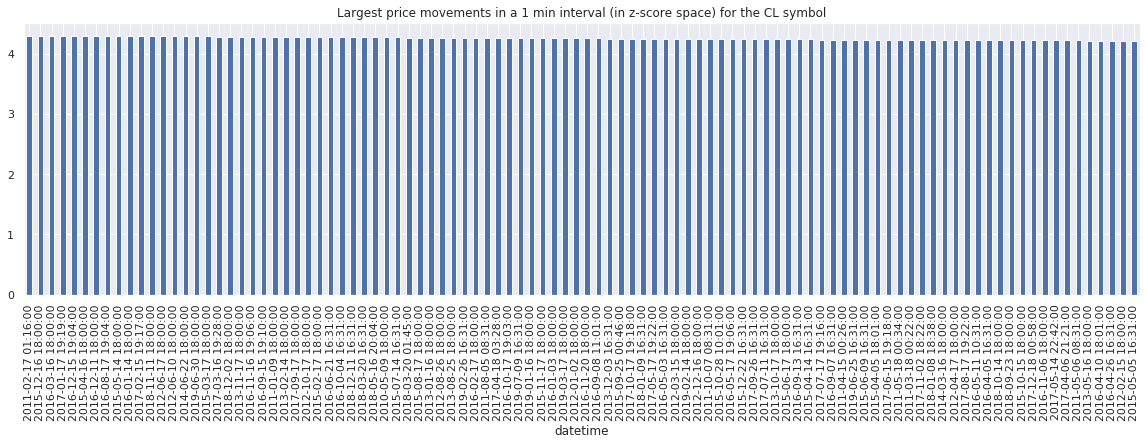

In [18]:
top_1min_movements.plot(kind="bar")
plt.title(
    f"Largest price movements in a 1 min interval (in z-score space) for the {SYMBOL} symbol"
)
plt.show()

In [19]:
top_1min_movements_by_year = zscored_1min_rets.resample("Y").apply(get_top_100)
top_1min_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-08 16:31:00    4.201319
            2009-11-22 18:00:00    4.163986
            2009-11-17 16:30:00    4.156503
            2009-12-16 10:31:00    4.154353
            2009-10-29 08:31:00    4.139635
Name: ret_0, dtype: float64

In [20]:
top_1min_pos_movements_by_year = pos_zscored_1min_rets.resample("Y").apply(
    get_top_100
)
top_1min_pos_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-08 16:31:00    4.201319
            2009-11-22 18:00:00    4.163986
            2009-11-17 16:30:00    4.156503
            2009-12-16 10:31:00    4.154353
            2009-10-29 08:31:00    4.139635
Name: ret_0, dtype: float64

In [21]:
top_1min_neg_movements_by_year = neg_zscored_1min_rets.resample("Y").apply(
    get_top_100, True
)
top_1min_neg_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-11-18 12:57:00   -4.154908
            2009-10-02 08:31:00   -4.142144
            2009-12-22 15:15:00   -4.115415
            2009-11-06 08:31:00   -4.053225
            2009-12-09 10:31:00   -4.035126
Name: ret_0, dtype: float64

# 5-min movements

In [ ]:
tau = 18

zscored_5min_rets = get_zscored_kibot_returns(
    five_min_prices, "minutely", tau=tau
)
abs_zscored_5min_rets = zscored_5min_rets.abs()
pos_zscored_5min_rets = zscored_5min_rets.loc[zscored_5min_rets >= 0]
neg_zscored_5min_rets = zscored_5min_rets.loc[zscored_5min_rets < 0]

top_5min_movements = get_top_100(zscored_5min_rets)

In [23]:
top_5min_movements.head()

datetime
2011-02-17 01:15:00    4.292089
2018-03-20 01:45:00    4.250278
2009-12-04 08:30:00    4.227688
2017-04-26 10:30:00    4.211947
2015-05-18 02:30:00    4.188955
Name: ret_0, dtype: float64

In [24]:
print(
    f"Top 100 of the 5-min price movements for {SYMBOL} occur at the following time:"
)
print(pd.Series(top_5min_movements.index).dt.time.value_counts())

Top 100 of the 5-min price movements for CL occur at the following time:
10:30:00    12
16:30:00    11
08:30:00     8
09:00:00     3
05:55:00     2
09:05:00     2
03:25:00     2
00:55:00     2
03:15:00     2
02:30:00     2
03:00:00     2
22:15:00     2
10:15:00     2
08:00:00     2
02:05:00     1
03:30:00     1
05:40:00     1
02:15:00     1
06:05:00     1
03:35:00     1
06:55:00     1
00:30:00     1
22:40:00     1
10:35:00     1
01:20:00     1
09:20:00     1
21:50:00     1
05:05:00     1
21:20:00     1
07:55:00     1
02:45:00     1
11:25:00     1
04:25:00     1
00:40:00     1
01:15:00     1
11:00:00     1
10:45:00     1
21:00:00     1
04:10:00     1
09:45:00     1
00:20:00     1
03:05:00     1
00:25:00     1
01:45:00     1
07:45:00     1
07:40:00     1
02:10:00     1
11:50:00     1
07:00:00     1
08:15:00     1
05:45:00     1
08:20:00     1
04:35:00     1
21:40:00     1
02:35:00     1
04:40:00     1
04:00:00     1
05:00:00     1
20:40:00     1
07:20:00     1
Name: datetime, dtype: int6

In [25]:
top_5min_movements_by_year = zscored_5min_rets.resample("Y").apply(get_top_100)
top_5min_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-04 08:30:00    4.227688
            2009-12-16 10:30:00    4.026082
            2009-10-21 10:30:00    3.899341
            2009-11-04 10:30:00    3.856698
            2009-10-29 08:30:00    3.805263
Name: ret_0, dtype: float64

In [26]:
top_5min_movements_by_year.tail()

datetime    datetime           
2019-12-31  2019-03-11 19:15:00    3.151518
            2019-01-02 09:55:00    3.142725
            2019-03-05 02:00:00    3.127936
            2019-05-06 13:15:00    3.121631
            2019-07-03 02:15:00    3.116008
Name: ret_0, dtype: float64

In [27]:
top_5min_pos_movements_by_year = pos_zscored_5min_rets.resample("Y").apply(
    get_top_100
)
top_5min_pos_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-12-04 08:30:00    4.227688
            2009-12-16 10:30:00    4.026082
            2009-10-21 10:30:00    3.899341
            2009-11-04 10:30:00    3.856698
            2009-10-29 08:30:00    3.805263
Name: ret_0, dtype: float64

In [28]:
top_5min_neg_movements_by_year = neg_zscored_5min_rets.resample("Y").apply(
    get_top_100, True
)
top_5min_neg_movements_by_year.head()

datetime    datetime           
2009-12-31  2009-10-02 08:30:00   -3.995286
            2009-12-29 06:55:00   -3.892555
            2009-10-07 10:30:00   -3.815435
            2009-11-06 08:30:00   -3.802023
            2009-11-13 09:00:00   -3.747532
Name: ret_0, dtype: float64